# NLP Standard Project
Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:
Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [249]:
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import torch

#metrics
from sklearn.metrics import classification_report

## Data Loading

Load the JSON in a Pandas Dataframe

In [250]:
file_path_train = 'MELD_train_efr.json'

df = pd.read_json(file_path_train)

df.shape

(4000, 5)

In [251]:
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


Drop episode column since it is only an index and it is not useful for the task

In [252]:
#df = df_train.drop(columns=['episode'])
#print(f"Dataframe shape after dropping column: {df.shape}")
#df.head()

## Preprocessing

### NaN values
Some trigger labels are not correctly formatted and appear as NaN -> we convert them to zero to avoid errors.

In [253]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [254]:
df["triggers"] = df["triggers"].apply(lambda x: [0.0 if elem != 1 and elem != 0 else elem for elem in x])

In [255]:
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


### Split data
80/10/10 train/val/test split

In [256]:
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 5)
Test shape: (400, 5)
Val shape: (400, 5)


In [257]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [258]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [259]:
print(f"Il discorso continua fino all'utterance numero 3205")
print(f"Dialogue: {df_test['utterances'][3205]}")

Il discorso continua fino all'utterance numero 3205
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this p

In [260]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [261]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


Effettivamente pare che il discorso venga splittato in due tra train e test però il prof specifica nelle raccomandazioni: "Given the dataset format, this property should be trivially guaranteed."

Dal forum: "According to the instructions, you are free to perform data splitting as you prefer and motivate your decision accordingly.
In other words, there is no explicit penalization for data splitting.
Note that this doesn't mean that potential issues/consequences are evaluated equally.
Think about what you would do in a real-world scenario.
To sum up, we evaluate your understanding of the problem and your corresponding actions."

In [262]:
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (397, 5)
Val shape: (398, 5)


In [263]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [264]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


Ancora un dialogo splittato tra test e val

In [265]:
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [266]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [267]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


Questa dovrebbe essere la shape dei dataset

In [268]:
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (398, 5)
Val shape: (397, 5)


### Data distributions
Is the train dataset imbalanced? Verify emotions and triggers

#### Emotions distribution

In [269]:
emotions_counts = {}
for emotions in df_train['emotions']:
    for emotion in emotions:
        if emotion in emotions_counts:
            emotions_counts[emotion] += 1
        else:
            emotions_counts[emotion] = 1

print(emotions_counts)

{'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}


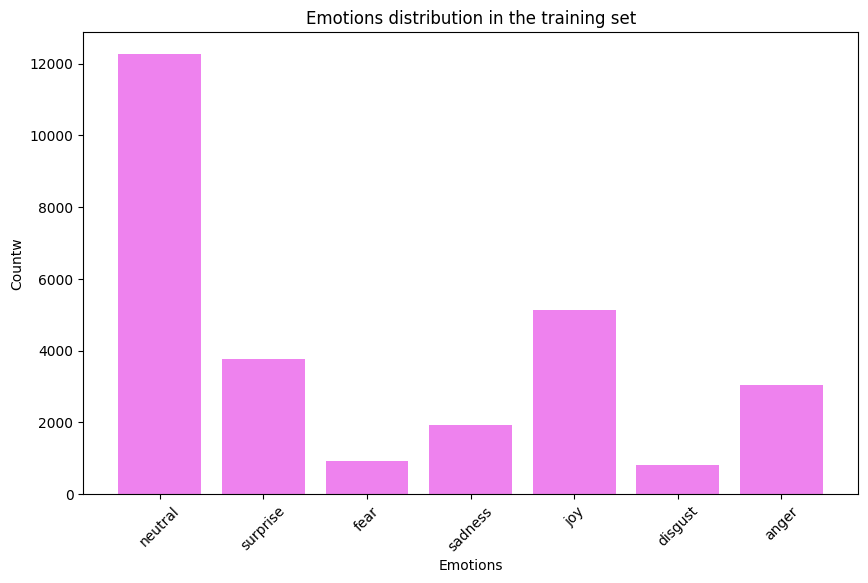

In [270]:
emotions = list(emotions_counts.keys())
emotion_counts = list(emotions_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color='violet')
plt.xlabel('Emotions')
plt.ylabel('Countw')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

### Triggers distribution

In [271]:
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


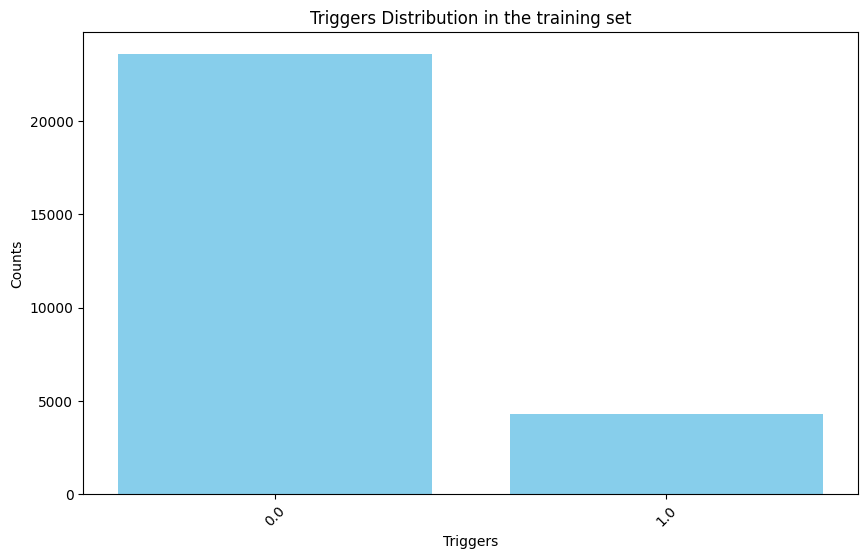

In [272]:
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color='skyblue')
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

As we can see both emotions and triggers are highly imbalanced, the emotion with the highest count is 'neutral' and the trigger with the highest count is '0.0'.

When a class imbalance exists within the training data, machine learning models will typically over-classify the larger classes due to their increased prior probability. As a result, the instances belonging to the smaller class(es) are typically misclassified more often than those belonging to the larger class(es).

How to deal with imbalanced data in classification? https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

Class weights penso sia la strategia migliore da adottare per questo caso

In [273]:
# Calcola i pesi delle classi
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts) * count) for emotion, count in emotions_counts.items()}

print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


Class weights computing using sklearn class_weight='balanced'

In [274]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

#weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

#save in dictionary
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


In [275]:
# Calcolo dei pesi per la colonna 'triggers'
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## Models definition

You should train and evaluate a BERT baseline on two different settings:
     
     - Freezed: we freeze the BERT embedding layer weights and fine-tune the classifier heads on top
     - Full: we fine-tune the whole model architecture.
     
Make sure you set a small enough batch size.  We recommend 1.

We recommend `bert-base-uncased`.

In addition, you should evaluate a random and a majority classifier for emotions and triggers.
You should report a comparison with your selected model(s) and the provided baselines

#### Baseline models
Defining random and majority dummy classifiers

In [276]:
random_emotions = DummyClassifier(strategy='uniform', random_state=42)
majority_emotions = DummyClassifier(strategy='most_frequent', random_state=42)

random_triggers = DummyClassifier(strategy='uniform', random_state=42)
majority_triggers = DummyClassifier(strategy='most_frequent', random_state=42)

## Evaluation Metrics

## Training and evaluation

### Fitting baseline models

Comincio a pensare che non è questo il modo di passare i dati al modello, ma forse sarebbe più utile splittare le utterances in un
singola frase e avere una struttura: (speaker) frase emotion trigger
speaker direi che è opzionale

Magari facciamo entrambe e vediamo qual è la performance migliore?

Va ancora fatto l'encoding del dataset

In [277]:
import json

name_columns = ["Dialogue_Id", "Speaker", "Emotion_type", "Utterance", "Value(0/1)"]

filtered_list = [df_train, df_val, df_test]
file_name = ["MELD_train", "MELD_val", "MELD_test"]

for index, name in enumerate(filtered_list):

  dataset = name.to_dict(orient='records')
  file_initials = str(filtered_list[0])

  episodes_list = [entry['episode'] for entry in dataset]
  speakers_list = [entry['speakers'] for entry in dataset]
  utterances_list = [entry['utterances'] for entry in dataset]
  emotions_list = [entry['emotions'] for entry in dataset]
  triggers_list = [entry['triggers'] for entry in dataset]

  data = [[], [], [], [], []]

#Succede spesso che ci siano episodi che hanno in comune diverse frasi
#e che inziano sempre allo stesso modo.

# Questa qua sotto è la parte in cui si modifica l'id del dialogo facendo in modo
# che se si incontrano utterances presenti anche in episodi precedenti, queste
# avranno lo stesso id perchè si riferiscono allo stesso discorso.



  N = len(dataset)

  first_sentence = None
  id_dialog = -1

  for i in range(N):
    if first_sentence != utterances_list[i][0]:
        id_dialog  += 1
        first_sentence = utterances_list[i][0]

    for j in range(len(utterances_list[i])):
        data[0].append(id_dialog)
        data[1].append(speakers_list[i][j])
        data[2].append(emotions_list[i][j])
        data[3].append(utterances_list[i][j])
        data[4].append(triggers_list[i][j])

    for k in range(5):
        data[k].append("/")

  df = pd.DataFrame(data)
  df = df.transpose()
  df.columns = name_columns
  df.to_csv(file_name[index] + ".csv", index=False)

In [278]:
df_train = pd.read_csv("MELD_train.csv")
df_val = pd.read_csv("MELD_val.csv")
df_test = pd.read_csv("MELD_test.csv")

L'ottava emozione, così come il terzo trigger sarà a "/" ?

In [279]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['Emotion_type'] = le.fit_transform(df_train['Emotion_type'])
df_val['Emotion_type'] = le.transform(df_val['Emotion_type'])
df_test['Emotion_type'] = le.transform(df_test['Emotion_type'])

#print(set(df_train['Emotion_type'].tolist()))
label_mapping = {label: index for index, label in enumerate(le.classes_)}
inverse_label_mapping = {index: label for label, index in label_mapping.items()}

#idx2label = {1:"anger", 5: "neutral", 7: "surprise"}
#print("Mappatura delle etichette:")
#print(label_mapping)

#print(df_val.iloc[10])

In [280]:
X_train = df_train.drop(columns=['Emotion_type', 'Value(0/1)'])
print(X_train.shape)

y_train_emotions = df_train['Emotion_type'].tolist()
y_train_triggers = df_train['Value(0/1)'].tolist()

(31090, 3)


In [281]:
X_test = df_test.drop(columns=['Emotion_type', 'Value(0/1)'])
print(X_test.shape)

y_test_emotions = df_test['Emotion_type']
y_test_triggers = df_test['Value(0/1)']

(3931, 3)


In [282]:
random_emotions.fit(X_train, y_train_emotions)
majority_emotions.fit(X_train, y_train_emotions)

random_triggers.fit(X_train, y_train_triggers)
majority_triggers.fit(X_train, y_train_triggers)

DummyClassifier(random_state=42, strategy='most_frequent')

### Evaluating baseline models

Ho notato che c'è una differenza in quantità tra i valori che sono stati predetti e i valori che ci sono nel set di test

In [283]:
y_pred_random_emotions = random_emotions.predict(X_test)
print(f"\nprediction: {y_pred_random_emotions[3929]}\nreal: {y_test_emotions[3929]}")
y_pred_majority_emotions = majority_emotions.predict(X_test)

y_pred_random_triggers = random_triggers.predict(X_test)
y_pred_majority_triggers = majority_triggers.predict(X_test)


print(f"\nprediction: {y_pred_random_triggers[3929]}\nreal: {y_test_triggers[3929]}")


prediction: 1
real: 4

prediction: /
real: 1.0


In [284]:
import seaborn as sns

def plot_baseline(cm):
    plt.figure(figsize=(15,20))
    for i, category_cm in enumerate(cm):
        plt.subplot(1, 2, i+1)
        sns.heatmap(category_cm, annot=True, fmt='.1%', cmap='Blues')
        plt.title(f'Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.show()

Classification report e Confusion Matrix per le baseline che predicono le emozioni

Classification report for random emotions:
{'0': {'precision': 0.11055276381909548, 'recall': 0.0873015873015873, 'f1-score': 0.0975609756097561, 'support': 504.0}, '1': {'precision': 0.12307692307692308, 'recall': 0.11290322580645161, 'f1-score': 0.1177707676130389, 'support': 496.0}, '2': {'precision': 0.125, 'recall': 0.02386117136659436, 'f1-score': 0.04007285974499089, 'support': 461.0}, '3': {'precision': 0.10743801652892562, 'recall': 0.025691699604743084, 'f1-score': 0.04146730462519937, 'support': 506.0}, '4': {'precision': 0.11458333333333333, 'recall': 0.12915851272015655, 'f1-score': 0.12143514259429623, 'support': 511.0}, '5': {'precision': 0.13554817275747508, 'recall': 0.4146341463414634, 'f1-score': 0.20430645968953431, 'support': 492.0}, '6': {'precision': 0.1174785100286533, 'recall': 0.08453608247422681, 'f1-score': 0.09832134292565947, 'support': 485.0}, '7': {'precision': 0.11617312072892938, 'recall': 0.10714285714285714, 'f1-score': 0.11147540983606556, 'support'

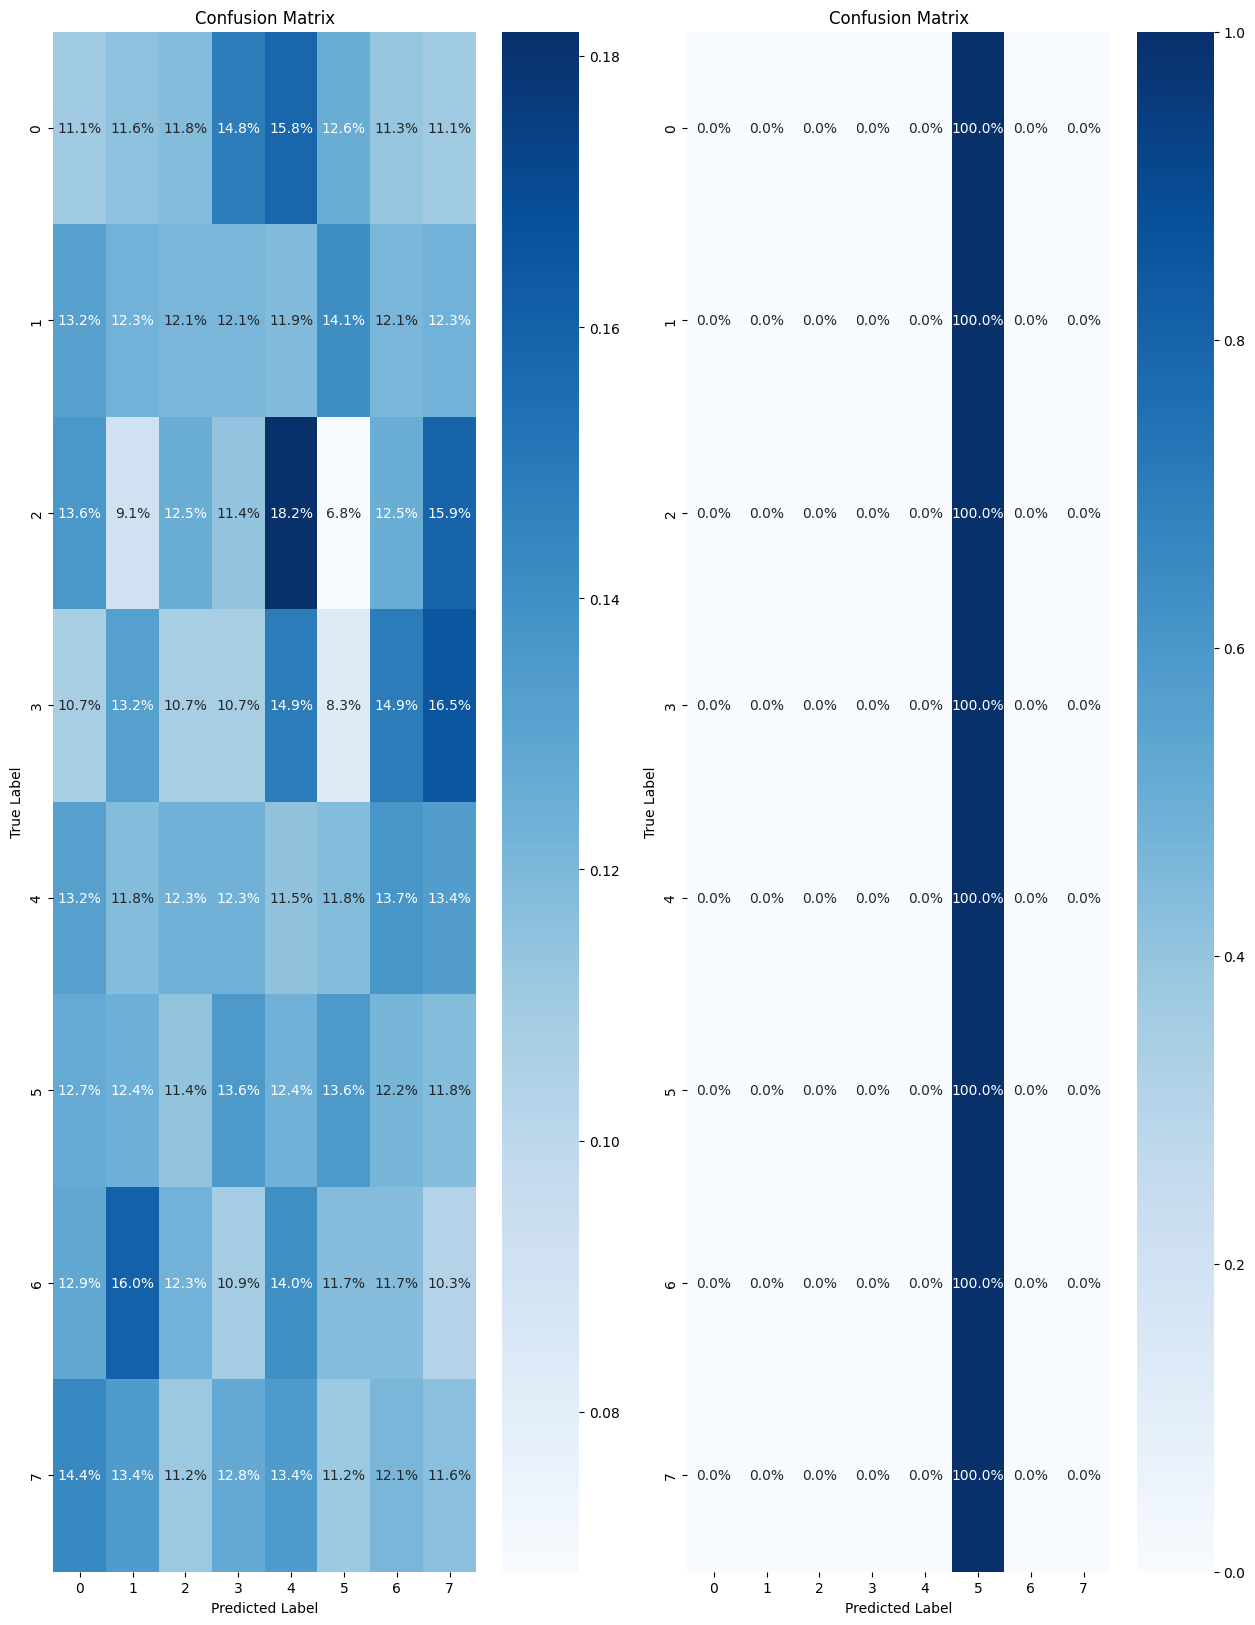

In [285]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report

cr_random_em = classification_report(y_pred_random_emotions, y_test_emotions, output_dict=True, zero_division=0)
cr_majority_em = classification_report(y_pred_random_emotions, y_test_emotions, output_dict=True, zero_division=0)

print("Classification report for random emotions:")
print(cr_random_em)

print("Classification report for majority emotions:")
print(cr_majority_em)

cm_random_em = confusion_matrix(y_test_emotions, y_pred_random_emotions , normalize='true')
cm_majority_em = confusion_matrix(y_test_emotions, y_pred_majority_emotions , normalize='true')

plot_baseline([cm_random_em, cm_majority_em])



Classification Report e Confusion Matrix per le predizioni riguardanti i trigger

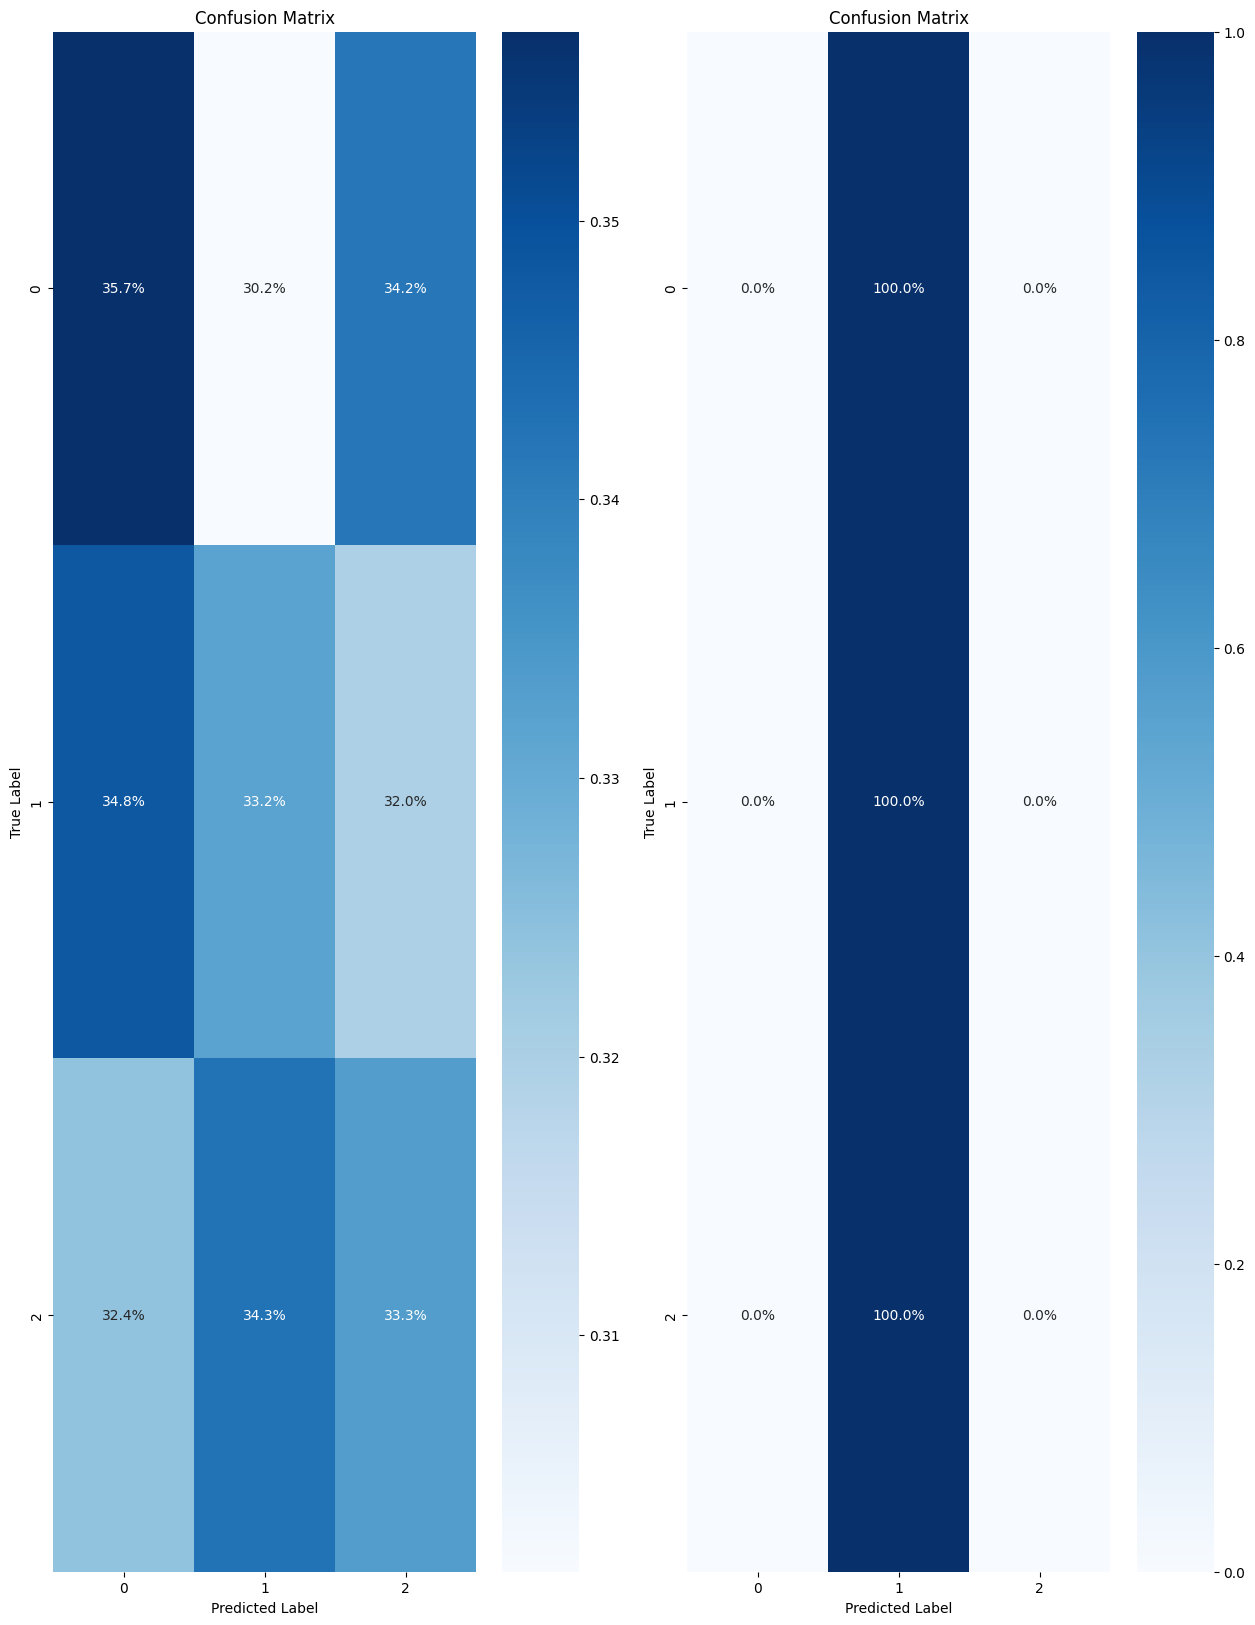

In [286]:
cr_random_tr = classification_report(y_pred_random_triggers, y_test_triggers, output_dict=True, zero_division=0)
cr_majority_tr = classification_report(y_pred_random_triggers, y_test_triggers, output_dict=True, zero_division=0)

cm_random_tr = confusion_matrix(y_test_triggers, y_pred_random_triggers , normalize='true')
cm_majority_tr = confusion_matrix(y_test_triggers, y_pred_majority_triggers , normalize='true')

plot_baseline([cm_random_tr, cm_majority_tr])
